In [1]:
## Asset Allocation Model
# Two LETF with Dynamic Allocation
# Case 3: Yearly Balancing

In [2]:
import zipline
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules, set_benchmark, get_datetime

from datetime import datetime
import pytz

from matplotlib import pyplot as plt, ticker, rc
import pandas as pd
import numpy as np
from scipy import stats

import pyfolio as pf

In [3]:
"""
    Model Settings
"""
initial_portfolio = 10000
vola_window = 20
YEAR_START = [1]

def volatility(ts):
    std = ts.pct_change().dropna().rolling(vola_window).std().mean() #iloc[-1]
    return std
#    return ts.pct_change().rolling(vola_window).std().iloc[-1]

def output_progress(context):
    """
        Output some performance numbers during backtest
    """
    # get today's date
    today = zipline.api.get_datetime().date()
    
    # calculate percent diff since last month
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1
    
    # Print performance
    print("{} - Last Month Result: {:.2%}.".format(today, perf_pct))

    # Remember today's portfolio value for next month calc
    context.last_month = context.portfolio.portfolio_value
    
    # Print new allocation every quarter
#    if get_datetime().date().month in [x + 1 for x in QUARTER_STARTS]:
#        t = ""
#        for key, value in context.new_weight.items():
#            t += "{}: {:.2%} ".format(key, value)
#        print("{} - This Quarter New Allocation: {}.".format(today, t))
#        #print(context.new_weight)

In [4]:
def initialize(context):
    # Used only for progress report
    context.last_month = initial_portfolio
    # Used for history window
    context.vola_window = vola_window
    
    # ETF
    etfs = ['TMF', 'TQQQ']
    context.etfs = [symbol(s) for s in etfs]
    
    set_benchmark(False)
    
    # Schedule rebalance for once a quarter
    schedule_function(rebalance, date_rules.month_start(), time_rules.market_open())

In [5]:
def rebalance(context, data):
    # Output progress
    output_progress(context)
    
    # If the current month number is not in YEAR_START, don't do anything
    month_number = get_datetime().date().month
    if month_number not in YEAR_START:
        return
    
    # Otherwise execute rebalance
    # Get historical 126 day data for volatility calculation
    hist = data.history(context.etfs, "close", 126, "1d")
    hist = hist.dropna()
    
    # Calculate inverse volatility for etfs and make target positions weights
    vola_table = hist[context.etfs].apply(volatility)
    inv_vola_table = 1 / vola_table
    sum_inv_vola = np.sum(inv_vola_table)
    vola_target_weights = inv_vola_table / sum_inv_vola
    
#    context.new_weight = dict()
    
    for etf in context.etfs:
        weight = vola_target_weights[etf]
#        context.new_weight[etf] = weight
        order_target_percent(etf, weight)

In [6]:
# set start and end date
start = pd.to_datetime('2010-12-31', utc=True)
end = pd.to_datetime('2020-08-19', utc=True)

# start backtest
result = zipline.run_algorithm(
    start = start, 
    end = end, 
    initialize = initialize, 
    capital_base = initial_portfolio, 
    data_frequency = 'daily', 
    bundle = 'etf_db_data')

2011-01-03 - Last Month Result: 0.00%.
2011-02-01 - Last Month Result: 0.85%.
2011-03-01 - Last Month Result: 1.99%.
2011-04-01 - Last Month Result: 1.55%.
2011-05-02 - Last Month Result: 6.90%.
2011-06-01 - Last Month Result: 0.23%.


/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/empyrical/stats.py:711: RuntimeWarning: invalid value encountered in true_divide
  out=out,


2011-07-01 - Last Month Result: -3.50%.
2011-08-01 - Last Month Result: 6.62%.
2011-09-01 - Last Month Result: 4.31%.
2011-10-03 - Last Month Result: 19.67%.
2011-11-01 - Last Month Result: -0.04%.
2011-12-01 - Last Month Result: -4.00%.
2012-01-03 - Last Month Result: 4.13%.
2012-02-01 - Last Month Result: 9.80%.
2012-03-01 - Last Month Result: 6.90%.
2012-04-02 - Last Month Result: 5.65%.
2012-05-01 - Last Month Result: -0.32%.
2012-06-01 - Last Month Result: -0.16%.
2012-07-02 - Last Month Result: 3.63%.
2012-08-01 - Last Month Result: 3.35%.
2012-09-04 - Last Month Result: 6.63%.
2012-10-01 - Last Month Result: -1.95%.
2012-11-01 - Last Month Result: -8.71%.
2012-12-03 - Last Month Result: 1.98%.
2013-01-02 - Last Month Result: -1.48%.
2013-02-01 - Last Month Result: -3.89%.
2013-03-01 - Last Month Result: 3.70%.
2013-04-01 - Last Month Result: 2.07%.
2013-05-01 - Last Month Result: 11.34%.
2013-06-03 - Last Month Result: -4.47%.
2013-07-01 - Last Month Result: -8.61%.
2013-08-01 -

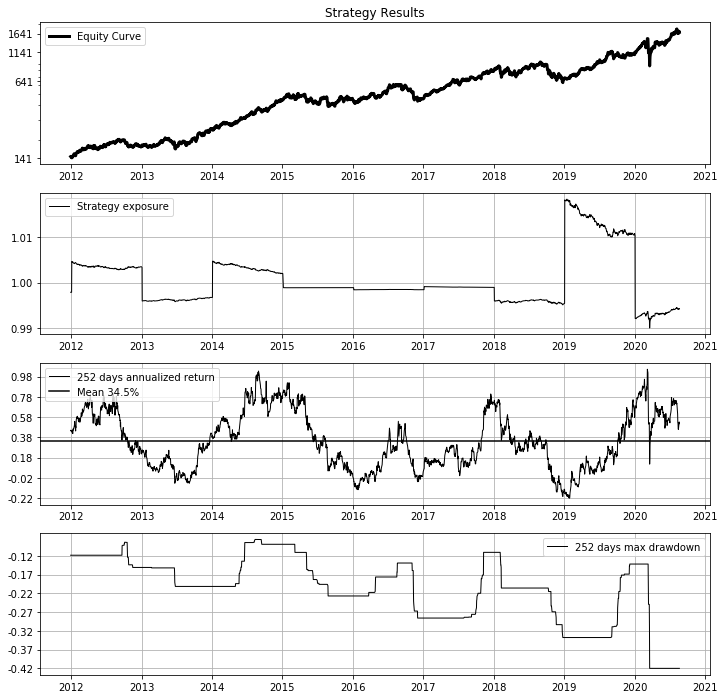

In [7]:
# Settings
window = 252
year_length = 252

# Copy the columns we need
df = result.copy().filter(items=['portfolio_value', 'gross_leverage'])

# Function for annualized return
def ann_ret(ts):
    return np.power((ts[-1] / ts[0]), (year_length/len(ts))) -1  

# Function for drawdown
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

# Get a rolling window
rolling_window = result.portfolio_value.rolling(window)

# Calculate rolling analytics
df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

# Drop initial n/a values
df.dropna(inplace=True)

# Make a figure
fig = plt.figure(figsize=(12, 12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(411)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], 
        linestyle='-', 
        color='black',
        label='Equity Curve', linewidth=3.0)

# Set log scale
ax.set_yscale('log') 

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# Add legend and grid
ax.legend()
ax.grid(False)

# Second chart
ax = fig.add_subplot(412)
ax.plot(df['gross_leverage'], 
        label='Strategy exposure'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.01 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Third chart
ax = fig.add_subplot(413)
ax.plot(df['annualized'], 
        label='{} days annualized return'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)
ax.axhline(df['annualized'].mean(), color='black', linewidth=1.5, label='Mean {:0.1f}%'.format(df['annualized'].mean() * 100))

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.2 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fourth chart
ax = fig.add_subplot(414)
ax.plot(df['drawdown'], 
        label='{} days max drawdown'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.05 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)





Entire data start date: 2010-12-31
Entire data end date: 2020-08-19


Backtest Months: 115


Performance statistics,Backtest
annual_return,0.34
annual_volatility,0.28
sharpe_ratio,1.19
calmar_ratio,0.82
stability_of_timeseries,0.98
max_drawdown,-0.42
omega_ratio,1.23
sortino_ratio,1.69
skew,-0.60
kurtosis,6.37


/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/timeseries.py:416: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  beta, alpha = sp.stats.linregress(factor_returns.loc[ret_index].values,
/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,41.70,2020-03-06,2020-03-18,2020-07-01,84
1,33.48,2018-08-29,2018-12-24,2019-06-20,212
2,28.28,2016-07-29,2016-12-01,2017-05-15,207
3,22.39,2015-03-24,2015-08-25,2016-04-07,273
4,20.28,2018-01-26,2018-02-08,2018-07-09,117




[-0.034 -0.072]


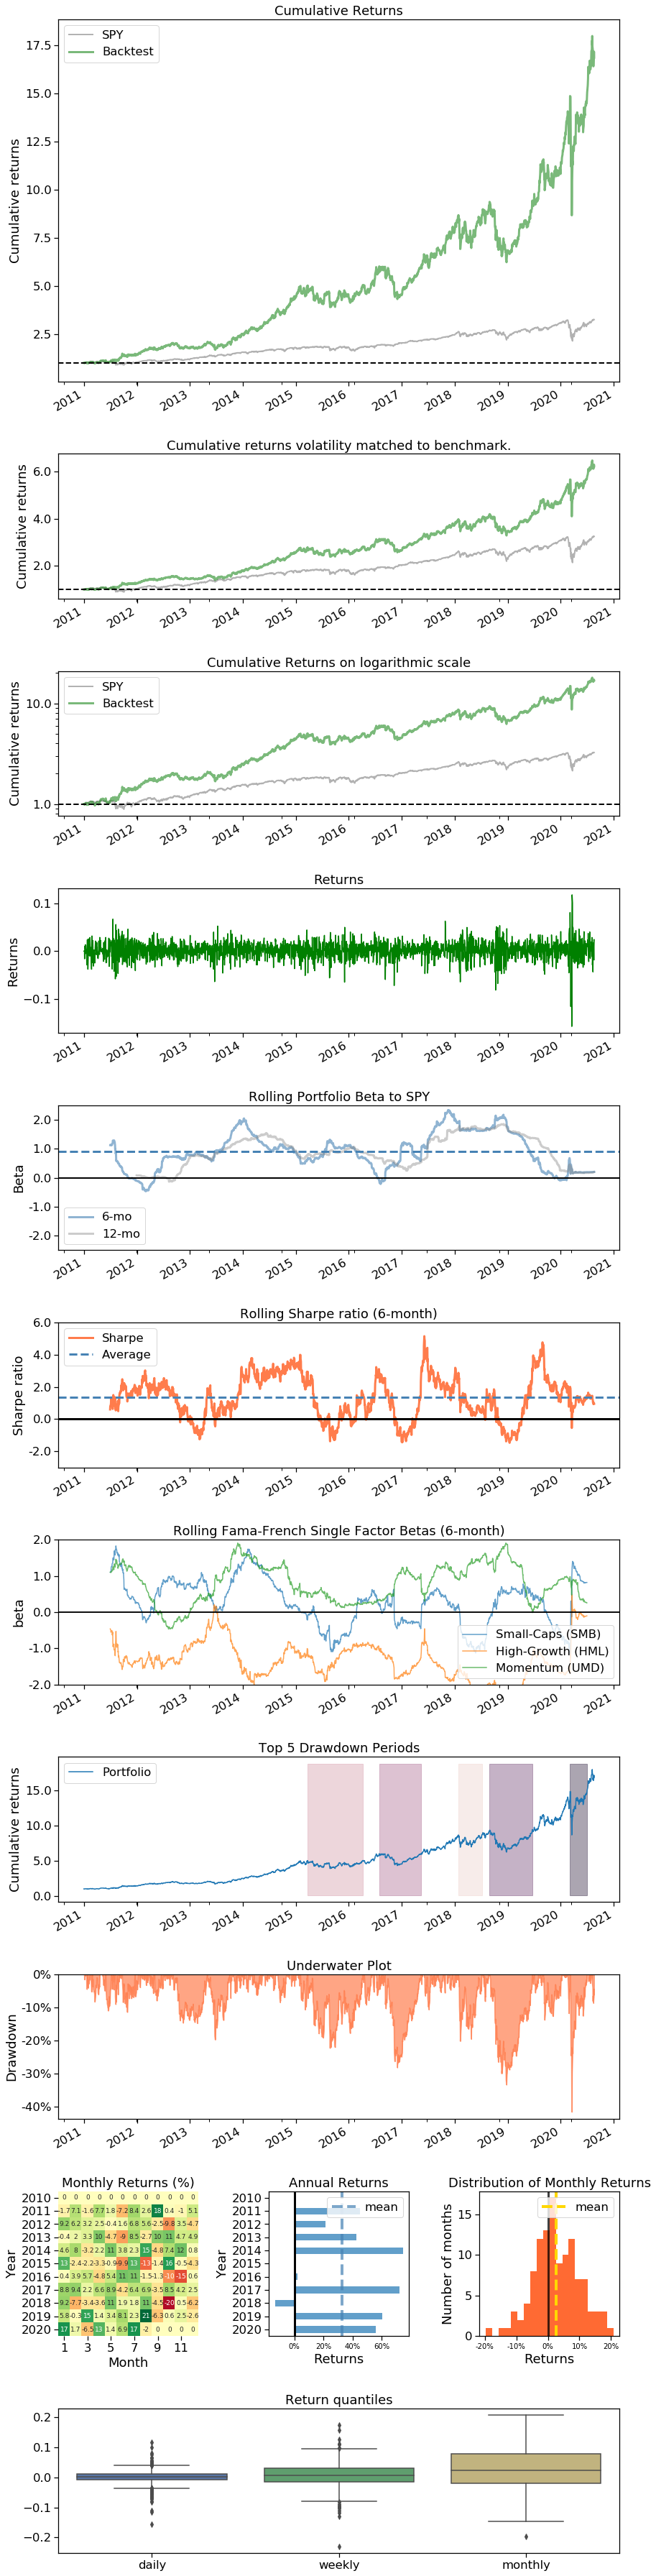

Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.36%,-5.81%,5.55%
Fukushima,0.14%,-2.49%,2.11%
EZB IR Event,-0.31%,-3.24%,1.80%
Apr14,0.20%,-2.88%,2.00%
Oct14,0.32%,-3.03%,2.69%
Fall2015,-0.43%,-5.59%,3.90%
Recovery,0.13%,-5.81%,6.68%
New Normal,0.13%,-15.72%,11.76%


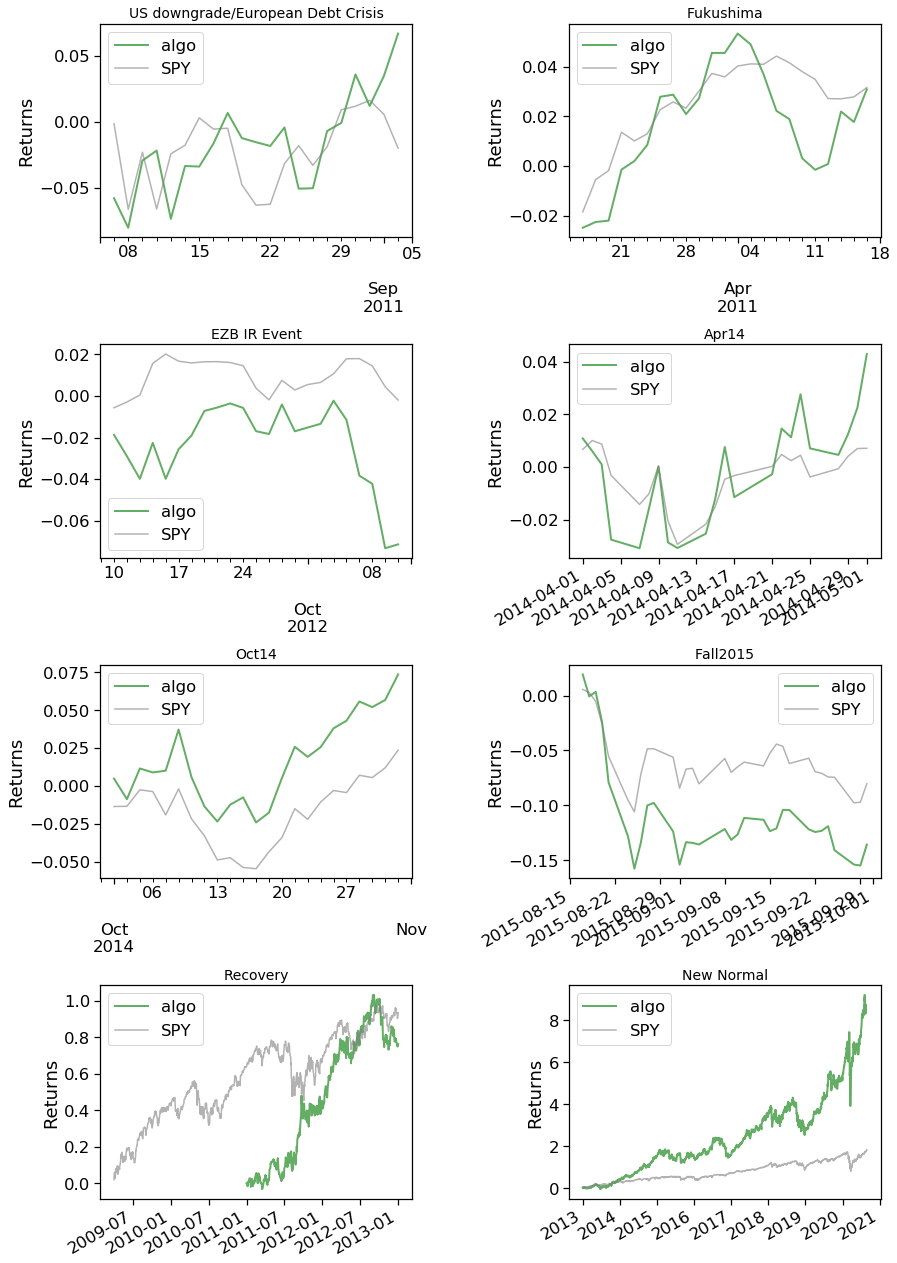

Top 10 long positions of all time,max
Equity(200 [TMF]),80.40%
Equity(204 [TQQQ]),75.85%


Top 10 short positions of all time,max


Top 10 positions of all time,max
Equity(200 [TMF]),80.40%
Equity(204 [TQQQ]),75.85%


All positions ever held,max
Equity(200 [TMF]),80.40%
Equity(204 [TQQQ]),75.85%


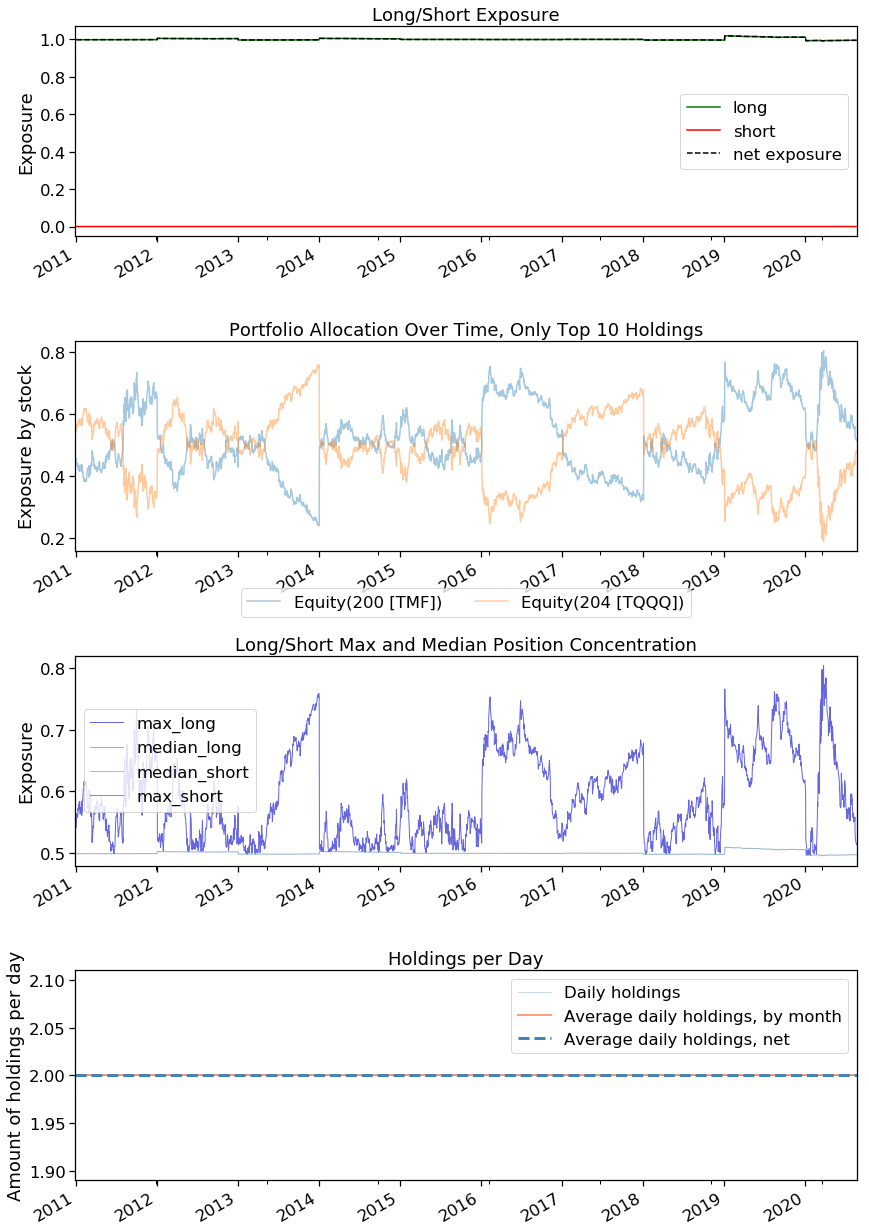

/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/plotting.py:1210: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  **kwargs)


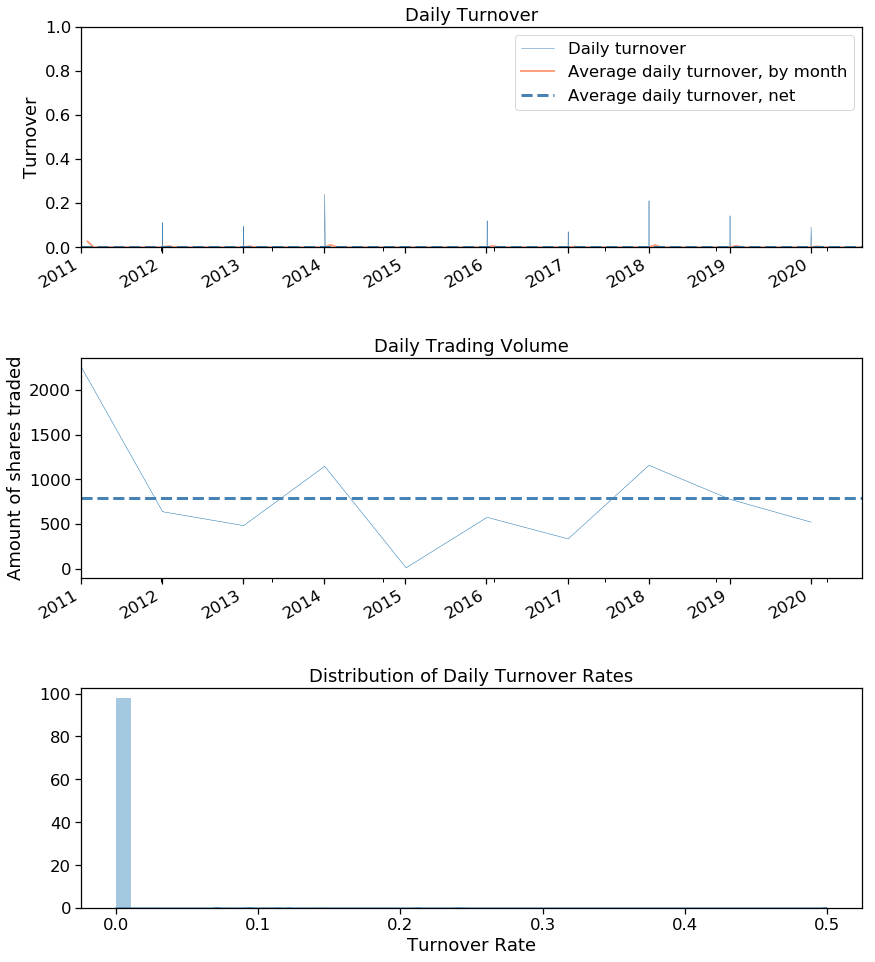

/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/round_trips.py:73: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/round_trips.py:76: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/round_trips.py:79: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/round_trips.py:83: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/round_trips.py:372: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  round

Summary stats,All trades,Long trades
Total number of round_trips,11.00,11.00
Percent profitable,1.00,1.00
Winning round_trips,11.00,11.00
Losing round_trips,0.00,0.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$158636.34,$158636.34
Gross profit,$158636.34,$158636.34
Gross loss,$0.00,$0.00
Profit factor,$nan,$nan
Avg. trade net profit,$14421.49,$14421.49
Avg. winning trade,$14421.49,$14421.49
Avg. losing trade,$nan,$nan
Ratio Avg. Win:Avg. Loss,$nan,$nan
Largest winning trade,$67269.88,$67269.88
Largest losing trade,$109.20,$109.20


Duration stats,All trades,Long trades
Avg duration,2000 days 08:43:38.363636,2000 days 08:43:38.363636
Median duration,2192 days 00:00:00,2192 days 00:00:00
Avg # round_trips per day,0.00,0.00
Avg # round_trips per month,0.08,0.08


Return stats,All trades,Long trades
Avg returns all round_trips,8.51%,8.51%
Avg returns winning,8.51%,8.51%
Avg returns losing,nan%,nan%
Median returns all round_trips,6.49%,6.49%
Median returns winning,6.49%,6.49%
Median returns losing,nan%,nan%
Largest winning trade,20.40%,20.40%
Largest losing trade,0.25%,0.25%


Symbol stats,Equity(200 [TMF]),Equity(204 [TQQQ])
Avg returns all round_trips,5.23%,10.15%
Avg returns winning,5.23%,10.15%
Avg returns losing,nan%,nan%
Median returns all round_trips,5.28%,10.76%
Median returns winning,5.28%,10.76%
Median returns losing,nan%,nan%
Largest winning trade,6.49%,20.40%
Largest losing trade,3.93%,0.25%


Profitability (PnL / PnL total) per name,pnl
symbol,
Equity(204 [TQQQ]),0.63%
Equity(200 [TMF]),0.37%


/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: Axis limits cannot be NaN or Inf

<Figure size 1008x1296 with 0 Axes>

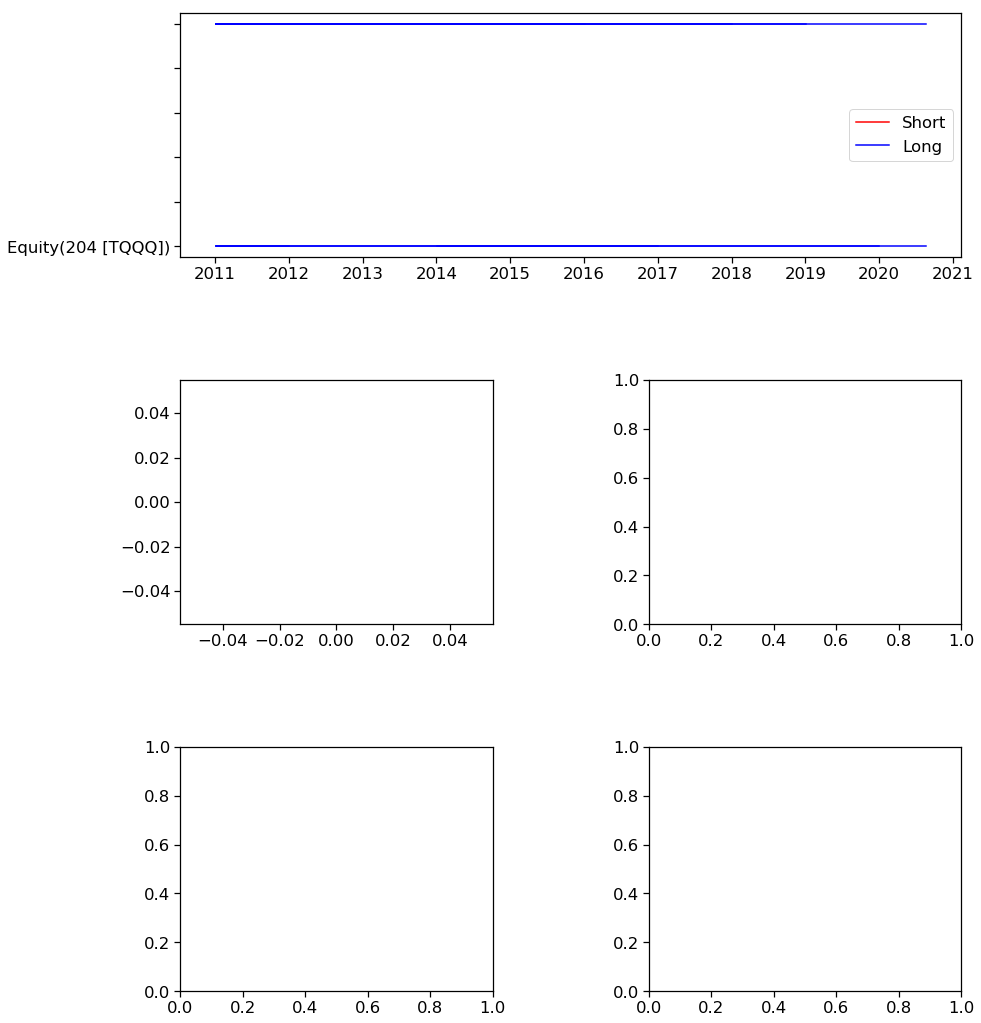

In [8]:
returns, positions, transactions, leverage = pf.utils.extract_rets_pos_txn_from_zipline(result)
pf.create_full_tear_sheet(returns, positions = positions, transactions = transactions, round_trips = True)

In [ ]:
# Portfolio snapshot

# day to view
day = '2020-08-03'

# get portfolio value and positions for this day
port_value = result.loc[day, 'portfolio_value']
day_positions = result.loc[day, 'positions']

df = pd.DataFrame(columns = ['value', 'pnl'])
# populate with position info
for pos in day_positions:
    ticker = pos['sid'].symbol
    df.loc[ticker,'value'] = pos['amount'] * pos['last_sale_price']
    df.loc[ticker,'pnl'] = df.loc[ticker,'value'] - (pos['amount'] * pos['cost_basis'])
    
# cash position
df.loc['cash', ['value', 'pnl']] = [(port_value - df['value'].sum()), 0]

# pie chart for allocation
fig, ax1 = plt.subplots(figsize = [12, 10])
ax1.pie(df['value'], labels = df.index, shadow = True, startangle = 90)
ax1.axis('equal')
ax1.set_title('Allocation on {}'.format(day))
plt.show()

# bar chart for open PnL
fig, ax1 = plt.subplots(figsize = [12, 10])
pnl_df = df.drop('cash')
ax1.barh(pnl_df.index, pnl_df['pnl'], align = 'center', color = 'green', ecolor = 'black')
ax1.set_title('Open PnL on {}'.format(day))
plt.show()

In [ ]:
# Portfolio Allocation of TMF and TQQQ
df1 = pd.DataFrame(index = result.index)
for day in result.index:
    port_value = result.loc[day, 'portfolio_value']
    positions = result.loc[day, 'positions']
    for pos in positions:
        ticker = pos['sid'].symbol
        df1.loc[day, ticker] = (pos['amount'] * pos['last_sale_price']) * 100 / port_value
        
print(df1.TMF.mean(), df1.TQQQ.mean())